In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import pandas as pd
from util import *

def tpr_at_fixed_fpr(pval, name):
    score_fp = jnp.load('results/fp_'+name+'.npy')
    score_tp = pd.read_csv('results/tp_'+name+'.csv')
    amp_names = list(score_tp.columns)
    amp = jnp.array([float(a) for a in amp_names])

    cutoff = -jnp.sort(-score_fp)[int(len(score_fp) * pval)]
        
    num_realizations= len(score_fp)
    tpr = jnp.array([(num_realizations - jnp.searchsorted(jnp.sort(jnp.array(score_tp[amp_name])), cutoff)) / num_realizations for amp_name in amp_names])
    return amp / 0.1, tpr
    

def read(name, test_stat= 'logB', test_found= False):
    df= pd.read_csv('../data/' + name + '.csv')
    
    scores = jnp.array(df[test_stat])
    
    mask = jnp.isfinite(jnp.array(df[test_stat]))
    #print(jnp.sum(mask))
    if test_found:
        period = jnp.array(df['period'])
        period_injected = jnp.array(df['period_injected'])
        not_found = jnp.abs(period - period_injected)/period_injected > 0.2
        #print(jnp.sum(not_found) / len(not_found))
        scores = -1e10 * not_found + (1-not_found) * scores
        
    return scores[mask]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


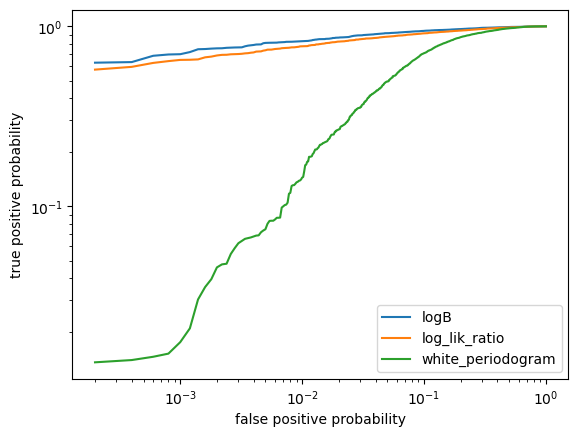

In [3]:
amp = '0.2'
remove_not_found = False
# score_fp = read('amp0.0', 'logB', False)
# score_tp = read('amp'+amp, 'logB', remove_not_found)
# plt.plot(*ROC(score_fp, score_tp), color = 'tab:blue', label = 'Bayes factor')


for test_stat in ['logB', 'log_lik_ratio', 'white_periodogram']:

#for test_stat in ['corr_periodogram', 'white_periodogram']:
    score_fp = read('amp0.0', test_stat, False)
    score_tp = read('amp'+amp, test_stat, remove_not_found)
    plt.plot(*ROC(score_fp, score_tp), label = test_stat)


plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
pmin = 1./len(score_fp)
#plt.xlim(pmin, 1)
#plt.ylim(pmin, 1)
plt.yscale('log')
plt.xscale('log')

plt.legend()
#plt.savefig(save_dir)
plt.show()

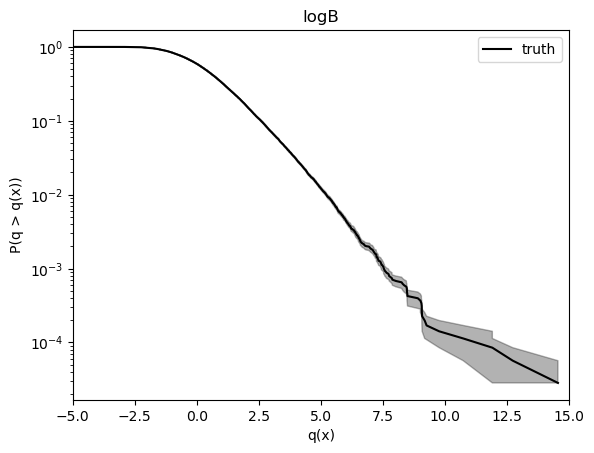

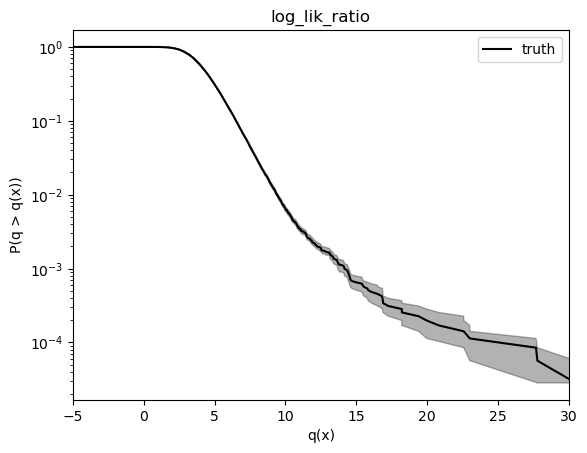

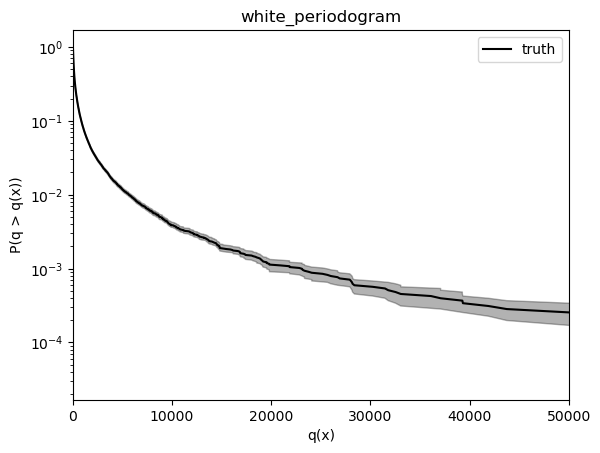

In [14]:
def cdf_plot(name, test_stat, label, color):
    score = read(name, test_stat, False)
    p, x, xmin, xmax = cdf_with_err(score)
    plt.plot(x, p, color = color, label = label)
    plt.fill_betweenx(p, xmin, xmax, color = color, alpha= 0.3)
    
for test_stat in ['logB', 'log_lik_ratio', 'white_periodogram']:
    plt.title(test_stat)
    cdf_plot('amp0.0', test_stat, 'truth', 'black')
    #cdf_plot('amp0.0_randomized', test_stat, 'randomized period', 'teal')
    
    plt.yscale('log')
    plt.xlabel('q(x)')
    plt.ylabel('P(q > q(x))')
    plt.legend()
    plt.xlim(-5, {'logB': 15, 'log_lik_ratio': 30, 'white_periodogram': 50000}[test_stat])
    plt.show()

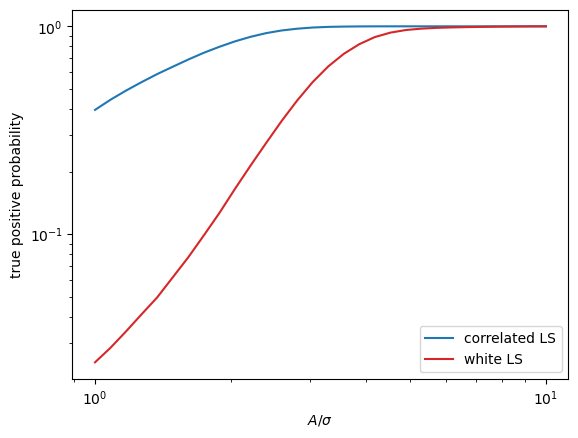

In [3]:

    
pval = 1e-2
plt.plot(*tpr_at_fixed_fpr(pval, 'corrLS'), label = 'correlated LS', color = 'tab:blue')
plt.plot(*tpr_at_fixed_fpr(pval, 'whiteLS'), label = 'white LS', color= 'tab:red')

plt.xlabel(r'$A / \sigma$')
plt.ylabel('true positive probability')
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.savefig(save_dir)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


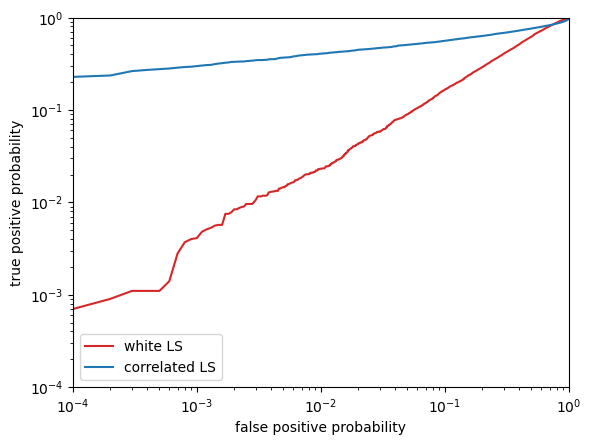

In [2]:
score_fp = jnp.load('results/fp_whiteLS.npy')
score_tp = jnp.load('results/tp_whiteLS.npy')
plt.plot(*ROC(score_fp, score_tp), color = 'tab:red', label = 'white LS')

score_fp = jnp.load('results/fp_corrLS.npy')
score_tp = jnp.load('results/tp_corrLS.npy')
plt.plot(*ROC(score_fp, score_tp), color = 'tab:blue', label = 'correlated LS')


plt.xlabel('false positive probability')
plt.ylabel('true positive probability')
pmin = 1./len(score_fp)
plt.xlim(pmin, 1)
plt.ylim(pmin, 1)
plt.yscale('log')
plt.xscale('log')

plt.legend()
#plt.savefig(save_dir)
plt.show()
